In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

# 1. Generate user-product data

In [2]:
np.random.binomial(n=3, p=0.1)

1

In [3]:
# 1. Generate data
num_prod = 8
num_users = 1000

dt = []
for n in range(num_users):
    engag = [np.random.binomial(n=5, p=0.1) for i in range(num_prod)]
    dt.append([n] + engag)
dt = pd.DataFrame(dt, columns=['userid'] + [f'p{i}' for i in range(num_prod)])
dt

,userid,p0,p1,p2,p3,p4,p5,p6,p7
0,0,0,0,1,2,0,1,1,0
1,1,1,0,0,1,0,0,1,0
2,2,0,1,1,0,0,1,1,2
3,3,0,1,0,0,0,0,0,0
4,4,1,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...
995,995,1,1,2,0,1,1,0,0
996,996,0,1,0,0,1,0,2,0
997,997,0,0,1,0,2,1,0,1
998,998,0,0,2,0,0,0,0,0


## Distribution of product engagement

<AxesSubplot:ylabel='Density'>

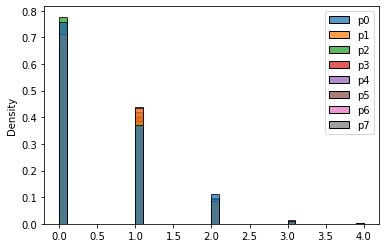

In [4]:
ticks = [f'p{i}' for i in range(num_prod)]
sns.histplot(data=dt[ticks], stat='density')

# 2. RBM
Two layers : visible variables and hidden variables

In [5]:
num_hiddens = num_prod + num_prod//2

visibles = tf.Variable(tf.zeros([num_prod]), tf.float32)
hiddens = tf.Variable(tf.zeros([num_hiddens]), tf.float32)

W = tf.Variable(tf.zeros([num_prod, num_hiddens]), tf.float32) # initial weights

In [6]:
W

<tf.Variable 'Variable:0' shape=(8, 12) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

Initial weights

In [7]:
v0 = tf.zeros([num_prod], tf.float32)

In [8]:
def hidden_layer(v0, W, hiddens, verbose=True): # forward propagation
    pH_V = tf.nn.sigmoid(tf.matmul([v0], W) + hiddens) # probabilities
    hstate = tf.nn.relu(pH_V - tf.random.uniform(tf.shape(pH_V))) # sampling H | x
    if verbose:
        print(f'p(H|V) shape  : {np.shape(pH_V)}')
        print(f'h state shape : {np.shape(hstate)}')
        print(f'hidden shape  : {np.shape(hiddens)}')
    return hstate

In [9]:
def recon(h0, W, visibles, verbose=True): # backward propagation
    pV_H = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + visibles) # probabilities
    vstate = tf.nn.relu(tf.sign(pV_H - tf.random.uniform(tf.shape(pV_H)))) # sampling v | H
    if verbose:
        print(f'p(V|H) shape  : {np.shape(pV_H)}')
        print(f'v state shape : {np.shape(vstate)}')
        print(f'visible shape : {np.shape(visibles)}')
    return vstate[0]

In [10]:
h0 = hidden_layer(v0, W, hiddens)
h0

p(H|V) shape  : (1, 12)
h state shape : (1, 12)
hidden shape  : (12,)


<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[0.05637944, 0.11523974, 0.0671581 , 0.        , 0.4971062 ,
        0.        , 0.        , 0.        , 0.03885484, 0.        ,
        0.44675887, 0.33551705]], dtype=float32)>

In [11]:
v0 = recon(h0, W, visibles)
v0

p(V|H) shape  : (1, 8)
v state shape : (1, 8)
visible shape : (8,)


<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 1., 0., 1., 0., 1., 1., 1.], dtype=float32)>

Training RBM

In [12]:
num_epoch = 100
batch_size = 250
lr = 0.01

In [13]:
if 'userid' in dt:
    del dt['userid']
norm_dt = dt.values / np.linalg.norm(dt.values)

train = tf.data.Dataset.from_tensor_slices(
    np.float32(norm_dt)).batch(batch_size)

In [14]:
hist = []
for epoch in range(num_epoch):
    for batch_id, batch in enumerate(train):
        
        accum_delta = []
        accum_loss = []
        for n in range(len(batch)):
            v0 = batch[n]
            h0 = hidden_layer(v0, W, hiddens, verbose=False)
            v1 = recon(h0, W, visibles, verbose=False)
            h1 = hidden_layer(v1, W, hiddens, verbose=False)

            delta = tf.matmul(tf.transpose([v0]), h0) - tf.matmul(tf.transpose([v1]), h1)
            accum_delta.append(delta)
            accum_loss.append(v1 - batch[n])
        
        # update weights (gradient descent)
        delta = np.mean(accum_delta, axis=0)
        W = W + delta * lr
        
        # update nodes
        visibles = visibles + lr * tf.reduce_mean(v0 - v1, 0)
        hiddens = hiddens + lr * tf.reduce_mean(h0 - h1, 0)
        
    # measure error (actual values vs reconstructed visible nodes)
    err = np.linalg.norm(np.mean(accum_loss))
    hist.append(err)
        
    #print(f'Epoch {epoch+1:2d} : Loss = {err:.3f}')

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

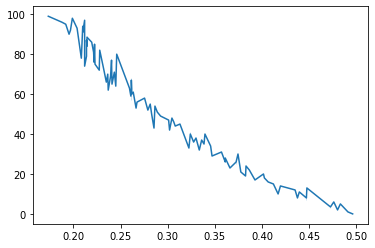

In [15]:
sns.lineplot(hist, np.arange(num_epoch))

In [16]:
W

<tf.Tensor: shape=(8, 12), dtype=float32, numpy=
array([[-0.12624288, -0.13076861, -0.12813702, -0.12818725, -0.13071075,
        -0.12917918, -0.128032  , -0.12890904, -0.12481257, -0.12914237,
        -0.1260244 , -0.13294582],
       [-0.12575586, -0.12774177, -0.1254813 , -0.12752295, -0.13005468,
        -0.12838814, -0.12673198, -0.12641747, -0.12324131, -0.1269685 ,
        -0.123993  , -0.1306049 ],
       [-0.1276756 , -0.12881753, -0.12707253, -0.12911375, -0.12960638,
        -0.12939441, -0.12840253, -0.12810272, -0.12551583, -0.1272088 ,
        -0.12702002, -0.13122799],
       [-0.12867238, -0.13162299, -0.127779  , -0.13052039, -0.13148461,
        -0.13130356, -0.13008943, -0.13006638, -0.12418298, -0.1267928 ,
        -0.12608889, -0.13106805],
       [-0.12621906, -0.12983583, -0.12924127, -0.12981819, -0.13012822,
        -0.13046981, -0.12900133, -0.12880579, -0.12629409, -0.12817734,
        -0.12547196, -0.13209817],
       [-0.12557562, -0.13000476, -0.12703946,

Test recommendation with RBM

In [17]:
U = tf.convert_to_tensor([
    [2, 0, 0, 1, 1, 0, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 1]
], dtype=tf.float32)
U = U / np.linalg.norm(U)
U

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[0.57735026, 0.        , 0.        , 0.28867513, 0.28867513,
        0.        , 0.28867513, 0.28867513],
       [0.28867513, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.28867513, 0.        , 0.        , 0.28867513,
        0.        , 0.        , 0.28867513]], dtype=float32)>

In [18]:
vv = []
for u in U:
    h0 = hidden_layer(u, W, hiddens, verbose=False)
    v1 = recon(h0, W, visibles, verbose=False)
    vv.append(v1.numpy())

In [19]:
U # original

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[0.57735026, 0.        , 0.        , 0.28867513, 0.28867513,
        0.        , 0.28867513, 0.28867513],
       [0.28867513, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.28867513, 0.        , 0.        , 0.28867513,
        0.        , 0.        , 0.28867513]], dtype=float32)>

In [20]:
vv # prediction

[array([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., 1., 0., 1., 0., 1.], dtype=float32)]

In [21]:
np.linalg.norm(U-vv)

2.6959133